<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Image_Classification/MNIST/MNIST_Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Dataset Classification

* Problem statement: Classify hand-written digits into their respective classes.
* Dataset to be used: keras.datasets.mnist

# Complete preliminaries

## Connect to Google Drive

In [1]:
### Use this for Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Keras Tuner

In [2]:
%%capture

!pip install -q -U keras-tuner

## Import required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os
import shutil
import pytz
import math
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models, Model
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.schedules import InverseTimeDecay 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import kerastuner as kt
from kerastuner import HyperModel

from sklearn.model_selection import train_test_split

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

## Define directory paths

In [4]:
# Define base path for TensorBoard Logs directory
tb_logs_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/TB_Logs/"
os.makedirs(tb_logs_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path for Keras Tuner Logs directory
kt_logs_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/KT_Logs/"
os.makedirs(kt_logs_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path for storing all outputs related to model / training
out_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/Training_Outputs/"
os.makedirs(out_base_path, exist_ok = True) # Don't raise any exception if directory exists

# Dataset - Import, EDA and pre-process

## Import dataset

In [5]:
# Download MNIST dataset
(X_train, y_train), (X_test_orig, y_test_orig) = mnist.load_data()
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of X_test is {X_test_orig.shape}")

11493376/11490434 [==============================] - 0s 0us/step
Shape of X_train is (60000, 28, 28)
Shape of X_test is (10000, 28, 28)


## Add channel axis to image arrays

In [6]:
X_train = np.expand_dims(X_train, axis = 3)
X_test_orig = np.expand_dims(X_test_orig, axis = 3)
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of X_test is {X_test_orig.shape}")

Shape of X_train is (60000, 28, 28, 1)
Shape of X_test is (10000, 28, 28, 1)


## Split test set into test and validation sets

In [7]:
# Split test set into test and validation sets
num_val_samp = 1000 # Number of validation set samples to generate
X_test, X_val, y_test, y_val = train_test_split(X_test_orig, y_test_orig,\
                                                test_size = num_val_samp, random_state = 1234)

## Get information about train, val and test datasets

In [8]:
print("Training_Set_Information:")
print("-------------------------")
print("Shape of training set data input is {}" .format(X_train.shape))
print("Number of training data samples is %d" %(X_train.shape[0]))
print("Shape of each training set sample is {}" .format(X_train.shape[1:3]))
print("Shape of training set output is {}" .format(y_train.shape))
print()
print("Validation_Set_Information:")
print("---------------------------")
print("Shape of validation set data input is {}" .format(X_val.shape))
print("Number of validation data samples is %d" %(X_val.shape[0]))
print("Shape of each validation set sample is {}" .format(X_val.shape[1:3]))
print("Shape of validation set output is {}" .format(y_val.shape))
print()
print("Test_Set_Information:")
print("--------------------:")
print("Shape of test set data input is {}" .format(X_test.shape))
print("Number of test data samples is %d" %(X_test.shape[0]))
print("Shape of each test set sample is {}" .format(X_test.shape[1:3]))
print("Shape of test set output is {}" .format(y_test.shape))

Training_Set_Information:
-------------------------
Shape of training set data input is (60000, 28, 28, 1)
Number of training data samples is 60000
Shape of each training set sample is (28, 28)
Shape of training set output is (60000,)

Validation_Set_Information:
---------------------------
Shape of validation set data input is (1000, 28, 28, 1)
Number of validation data samples is 1000
Shape of each validation set sample is (28, 28)
Shape of validation set output is (1000,)

Test_Set_Information:
--------------------:
Shape of test set data input is (9000, 28, 28, 1)
Number of test data samples is 9000
Shape of each test set sample is (28, 28)
Shape of test set output is (9000,)


In [9]:
print("Minimum value of training data samples is %d" %(X_train.min()))
print("Maximum value of training data samples is %d" %(X_train.max()))
print()
print("Minimum value of validation data samples is %d" %(X_val.min()))
print("Maximum value of validation data samples is %d" %(X_val.max()))
print()
print("Minimum value of test data samples is %d" %(X_test.min()))
print("Maximum value of training data samples is %d" %(X_test.max()))
print()

Minimum value of training data samples is 0
Maximum value of training data samples is 255

Minimum value of validation data samples is 0
Maximum value of validation data samples is 255

Minimum value of test data samples is 0
Maximum value of training data samples is 255



<b>Above data indicates that the images are encoded as 28 x 28 grayscale images encoded in 0 to 255 integer format.</b>

## Get class distribution

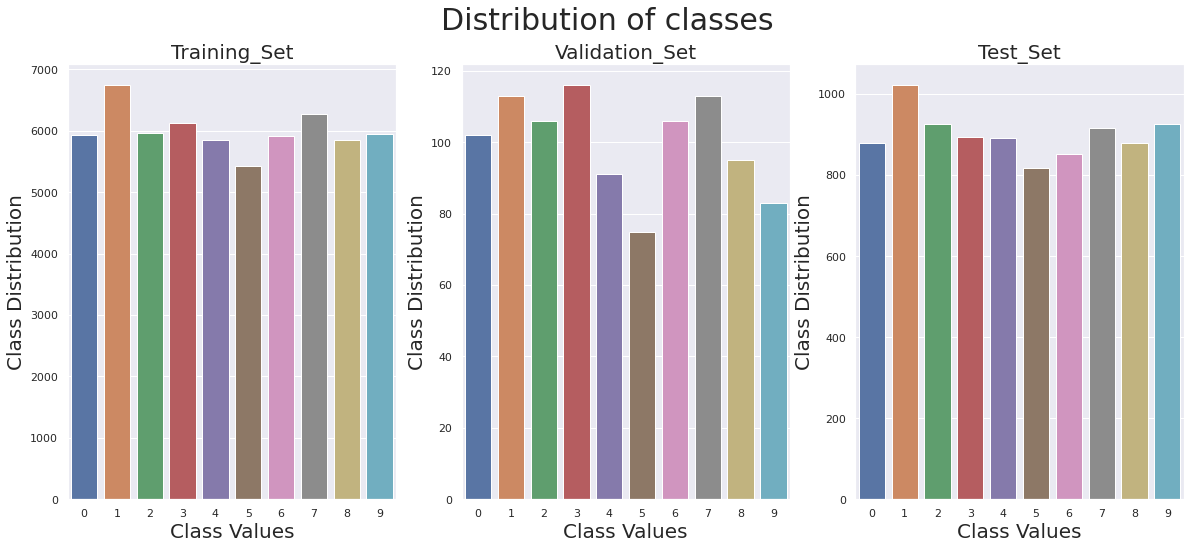

In [10]:
sns.set(color_codes = True)
fig = plt.figure(figsize = (20, 8))
fig.suptitle('Distribution of classes', fontsize = 30)

ax1 = plt.subplot(1, 3, 1)
sns.countplot(y_train)
ax1.set_title('Training_Set', fontsize = 20)
ax1.set_xlabel('Class Values', fontsize = 20)
ax1.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 2)
sns.countplot(y_val)
ax2.set_title('Validation_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 3)
sns.countplot(y_test)
ax2.set_title('Test_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)
plt.show()

In [11]:
# Collate class frequency counts into a dataframe
class_dist_df = pd.DataFrame(np.bincount(y_train), columns=['Training_Set'])
class_dist_df.index.name = 'Class_Label'
class_dist_df['Val_Set'] = np.bincount(y_val)
class_dist_df['Test_Set'] = np.bincount(y_test)

display(class_dist_df)

,Training_Set,Val_Set,Test_Set
Class_Label,,,
0,5923,102,878
1,6742,113,1022
2,5958,106,926
3,6131,116,894
4,5842,91,891
5,5421,75,817
6,5918,106,852
7,6265,113,915
8,5851,95,879


<b>Class distribution is reasonably uniform for all three sets.</b>

## Define Function: Visualize Data

In [12]:
def viz_data(name, X, y, X_dtype, mode, num_images, num_cols, col_size, row_size):

  '''
  Function to plot images along with labels from different sets

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    X: Image array (should be in (batch, height, width, channel)) format
    y: label array (Raw labels - should not be One-Hot encoded)
    X_dtype: Data Type of image array. One of 'Int' or 'Float'
    mode: One of 'grayscale' or 'color'
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig, ax = plt.subplots(num_rows, num_cols, figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = X.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_index): # Loop through samp_index
    if (X_dtype == 'int'):
      img = (X[value].squeeze()).astype('uint8') # Extract image and force type to uint8
    elif (X_dtype == 'float') :
      img = (X[value].squeeze()).astype('float32') # Extract image and force type to float32
    label = y[value] # Extract label
    ri = ind // num_cols # Row index
    ci = ind - num_cols * ri # Column index
    if (mode == 'grayscale'):
      ax[ri, ci].imshow(img, cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax[ri, ci].imshow(img) # Plot image in color

    ax[ri, ci].set_title("Class label is %d" %label, fontsize = 25)
    ax[ri, ci].grid(False)  

  plt.show()  

## Visualize Data

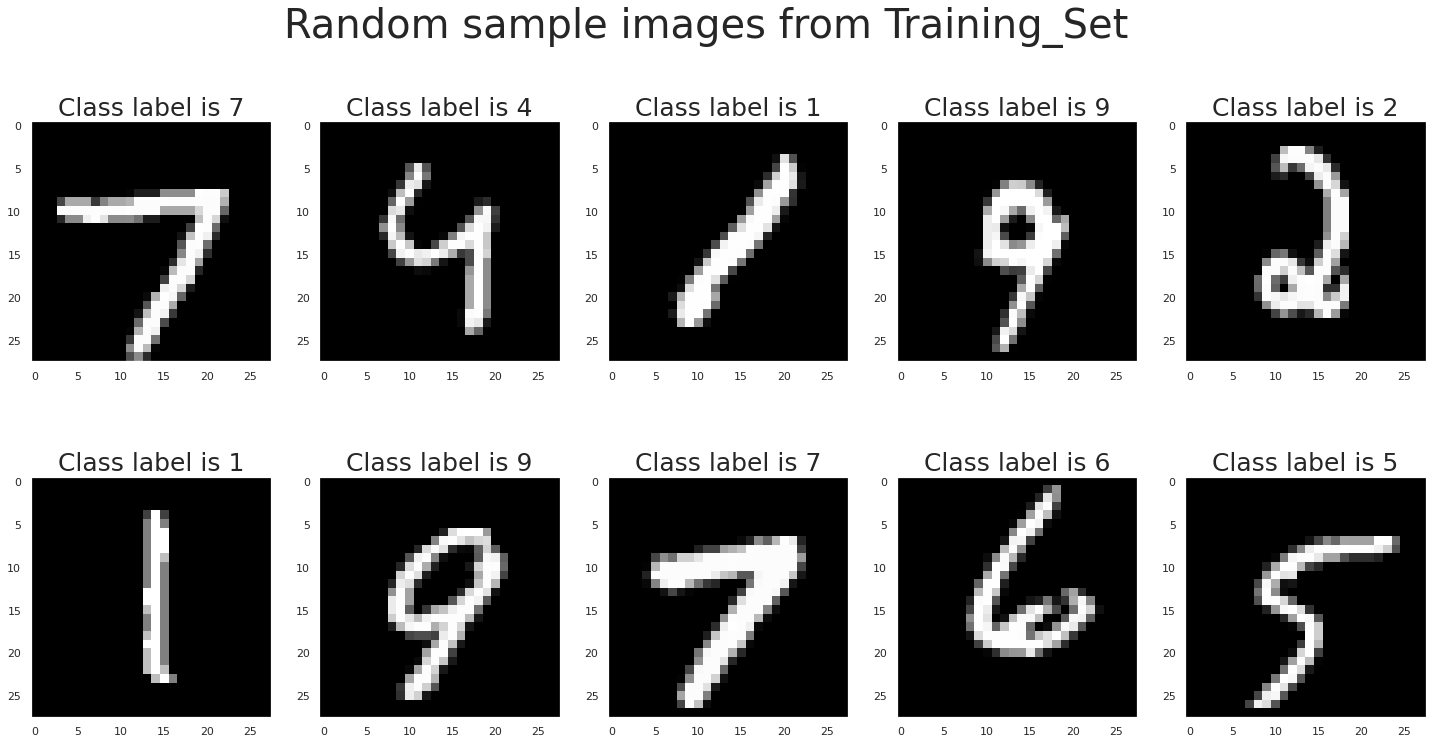

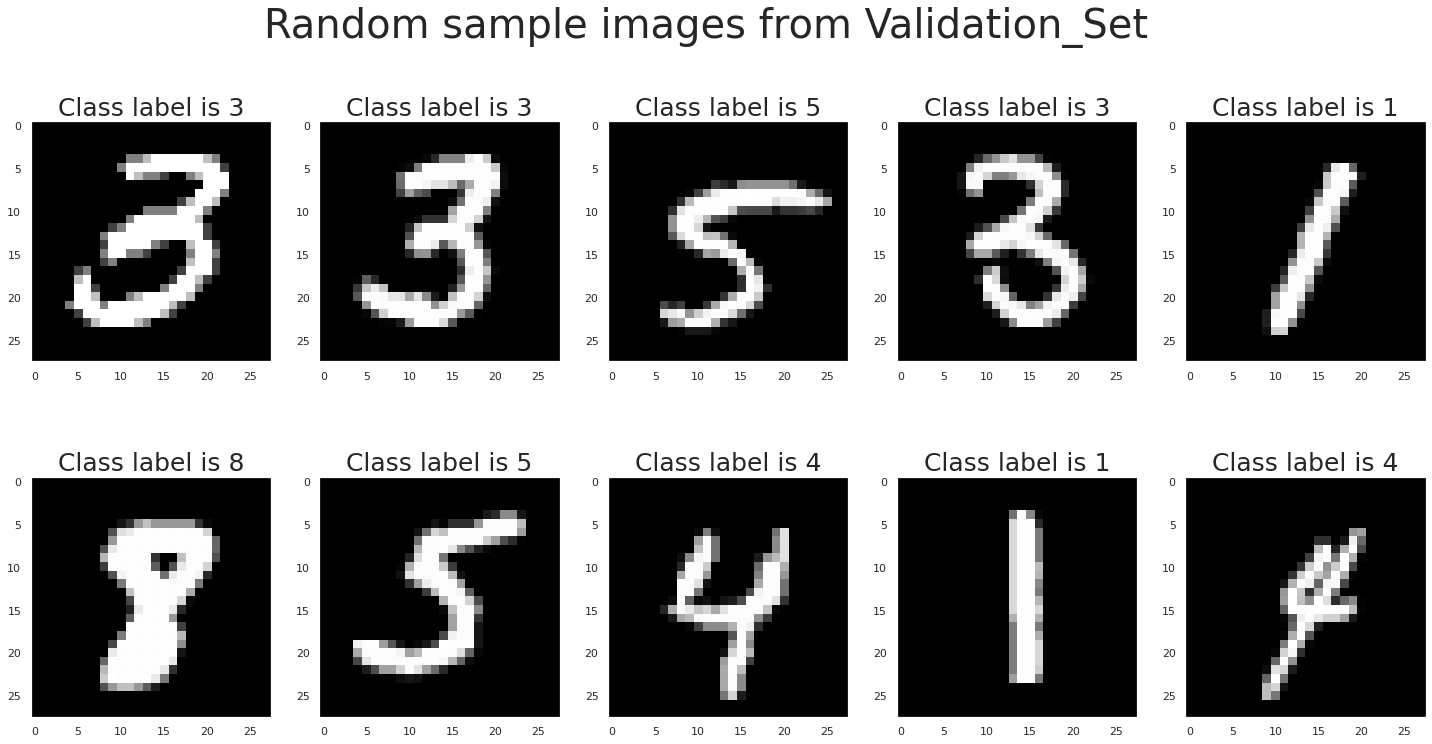

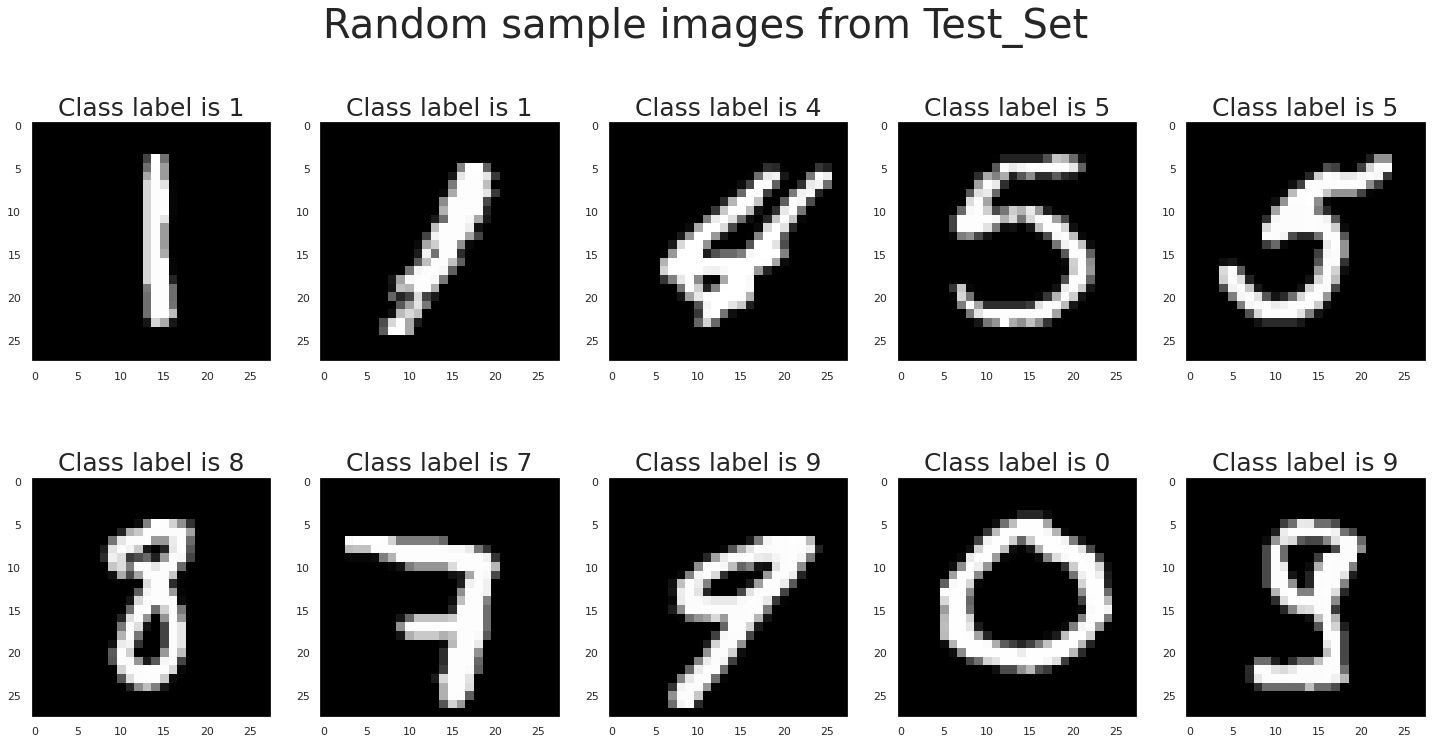

In [13]:
viz_data('Training_Set', X_train, y_train, 'int', 'grayscale', num_images = 10, num_cols = 5,\
         col_size = 5, row_size = 6)
print("\n\n")
viz_data('Validation_Set', X_val, y_val, 'int', 'grayscale', num_images = 10, num_cols = 5,\
         col_size = 5, row_size = 6)
print("\n\n")
viz_data('Test_Set', X_test, y_test, 'int', 'grayscale', num_images = 10, num_cols = 5,\
         col_size = 5, row_size = 6)


## One-hot encode training, validation and testing labels.

In [14]:
num_classes = 10 # Digits 0 to 9
y_train_ohe = to_categorical(y_train, num_classes = num_classes)
y_val_ohe = to_categorical(y_val, num_classes = num_classes)
y_test_ohe = to_categorical(y_test, num_classes = num_classes)
print("Shape of one-hot encoded training set output is {}" .format(y_train_ohe.shape))
print("Shape of one-hot encoded validation set output is {}" .format(y_val_ohe.shape))
print("Shape of one-hot encoded test set output is {}" .format(y_test_ohe.shape))

Shape of one-hot encoded training set output is (60000, 10)
Shape of one-hot encoded validation set output is (1000, 10)
Shape of one-hot encoded test set output is (9000, 10)


# Define Image Data Generators

## Define Function: plot_img_transf

In [15]:
def plot_img_transf(X, X_dtype, mode, rot, wid_shift, hgt_shift, shear, zx, zy,\
                    num_cols, col_size, row_size):

  # Generate random sample index
  samp_index = np.random.randint(low = 0, high = X.shape[0], size = 1)[0] 

  img_transf = {} # Dict place-holder to store original and transformed images
  img = X[samp_index] # Extract original image
  img_transf['Original_Image'] = img # Append original image to img_transf dict

  img_transf['Clockwise_Rotation'] = apply_affine_transform(img, theta = rot) # Clockwise rotn
  img_transf['Anti-clockwise Rotation'] = apply_affine_transform(img, theta = -rot) # Anti-clockwise rotn
  img_transf['Left_Shift'] = apply_affine_transform(img, ty = wid_shift) # Left Shift
  img_transf['Right_Shift'] = apply_affine_transform(img, ty = -wid_shift) # Right Shift
  img_transf['Upward_Shift'] = apply_affine_transform(img, tx = hgt_shift) # Upward Shift
  img_transf['Downward_Shift'] = apply_affine_transform(img, tx = -hgt_shift) # Downward Shift
  img_transf['Shear_Right'] = apply_affine_transform(img, shear = shear) # Right-upward shear
  img_transf['Shear_left'] = apply_affine_transform(img, shear = -shear) # Left-upward shear  
  img_transf['Zoom_X'] = apply_affine_transform(img, zx = zx) # Zoom in x-direction  
  img_transf['Zoom_Y'] = apply_affine_transform(img, zy = zy) # Zoom in y-direction    

  # shear=0, zx=1, zy=1, row_axis=0, col_axis=1

  num_images = len(img_transf) # Total number of images to plot
  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting
  
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Original image along with some affine transformations', fontsize = 40)

  for ind, dict_entry in enumerate(img_transf.items()): # Loop through dictionary items
    key, image = dict_entry[0], dict_entry[1]
    if (X_dtype == 'int'):
      img = (image.squeeze()).astype('uint8') # Extract image and force type to uint8
    elif (X_dtype == 'float') :
      img = (image.squeeze()).astype('float32') # Extract image and force type to float32
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    if (mode == 'grayscale'):
      ax.imshow(img, cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax.imshow(img) # Plot image in color
    ax.set_title(key, fontsize = 25) # Set key as title
    #ax.grid(False) # Turn off grid

  plt.show()    


## Visualize some image transformations

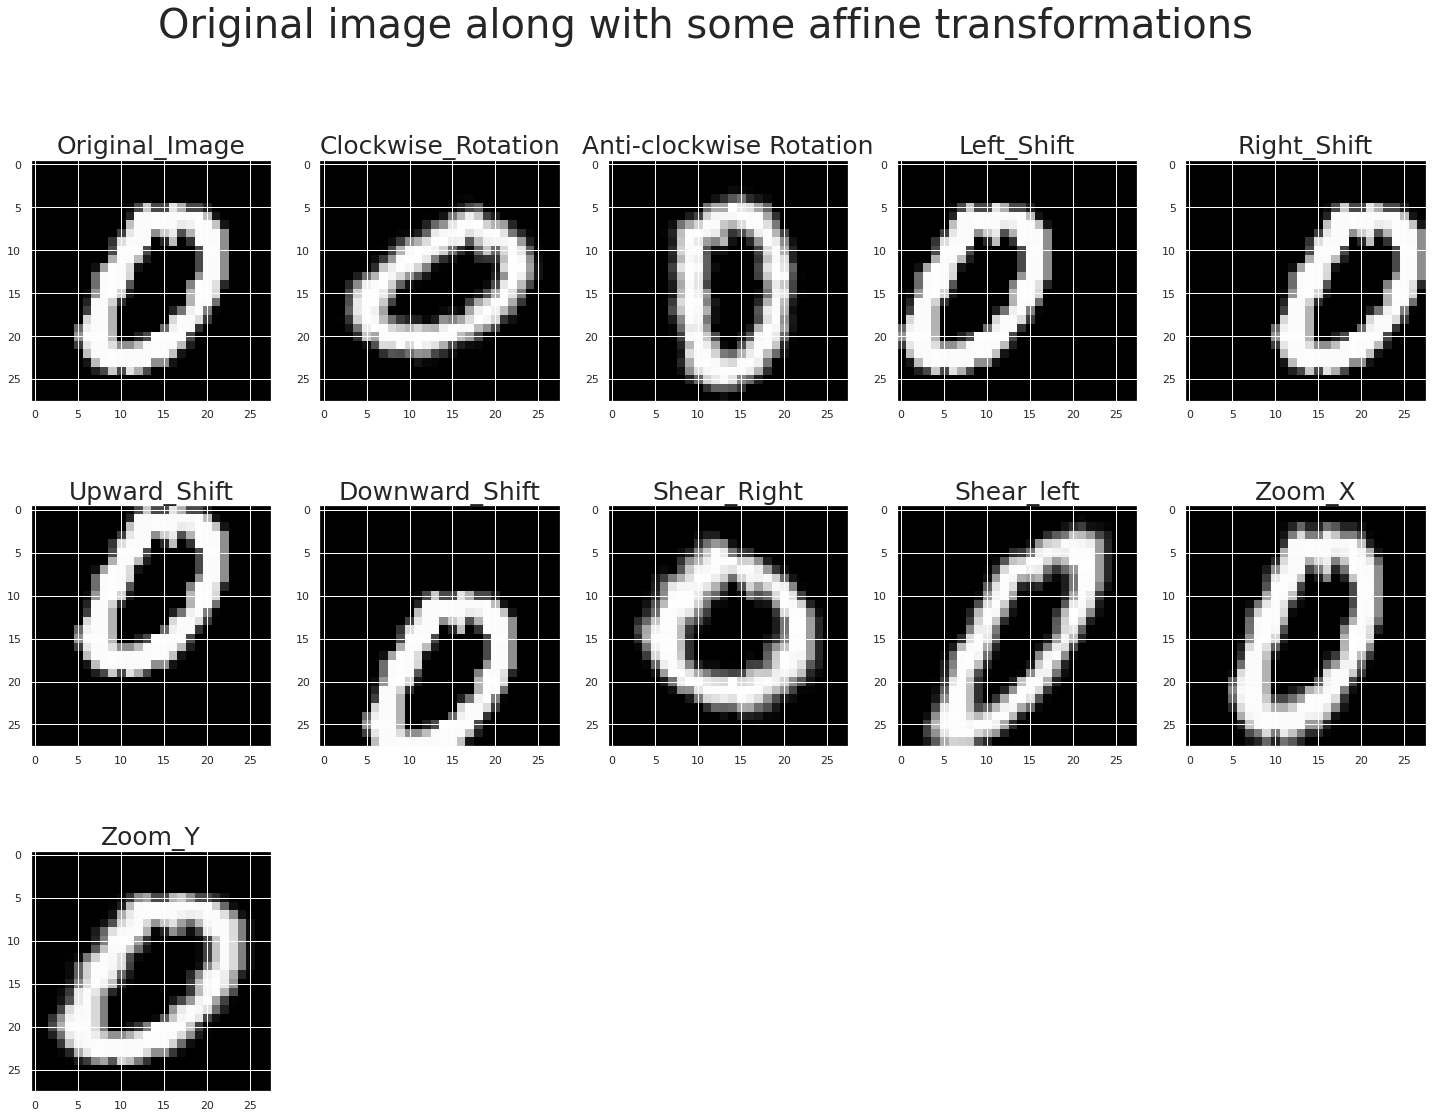

In [16]:
plot_img_transf(X_train, 'int', 'grayscale', rot = 30, wid_shift = 5, hgt_shift = 5, shear = 30,\
                zx = 0.8, zy = 0.8, num_cols = 5, col_size = 5, row_size = 6)

## Define Image Data Generators

In [17]:
# Define train, val and test ImageDataGenerator objects
# Train ImageDataGenerator included image augmentation
# Val and Test ImageDataGenerators don't have any image augmentation

train_datagen = ImageDataGenerator(rotation_range = 30, horizontal_flip = False, width_shift_range = 5,\
                                   height_shift_range = 5, shear_range = 20, zoom_range = 0.2,\
                                   channel_shift_range = 0.0, rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

## Define Generator Objects

In [18]:
mod_bat_size = 64 # Batch size to use for generator objects

# Define train, val and test generator objects
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size = mod_bat_size,\
                                     shuffle = True, seed = 1234)
val_generator = val_datagen.flow(X_val, y_val_ohe, batch_size = mod_bat_size,\
                                 shuffle = True, seed = 1234)
test_generator = test_datagen.flow(X_test, y_test_ohe, batch_size = mod_bat_size,\
                                   shuffle = True, seed = 1234)

print("Number of batches in train_generator is %d" %(len(train_generator)))
print("Number of batches in val_generator is %d" %(len(val_generator)))
print("Number of batches in test_generator is %d" %(len(test_generator)))

Number of batches in train_generator is 938
Number of batches in val_generator is 16
Number of batches in test_generator is 141


## Visualize the data from generator objects

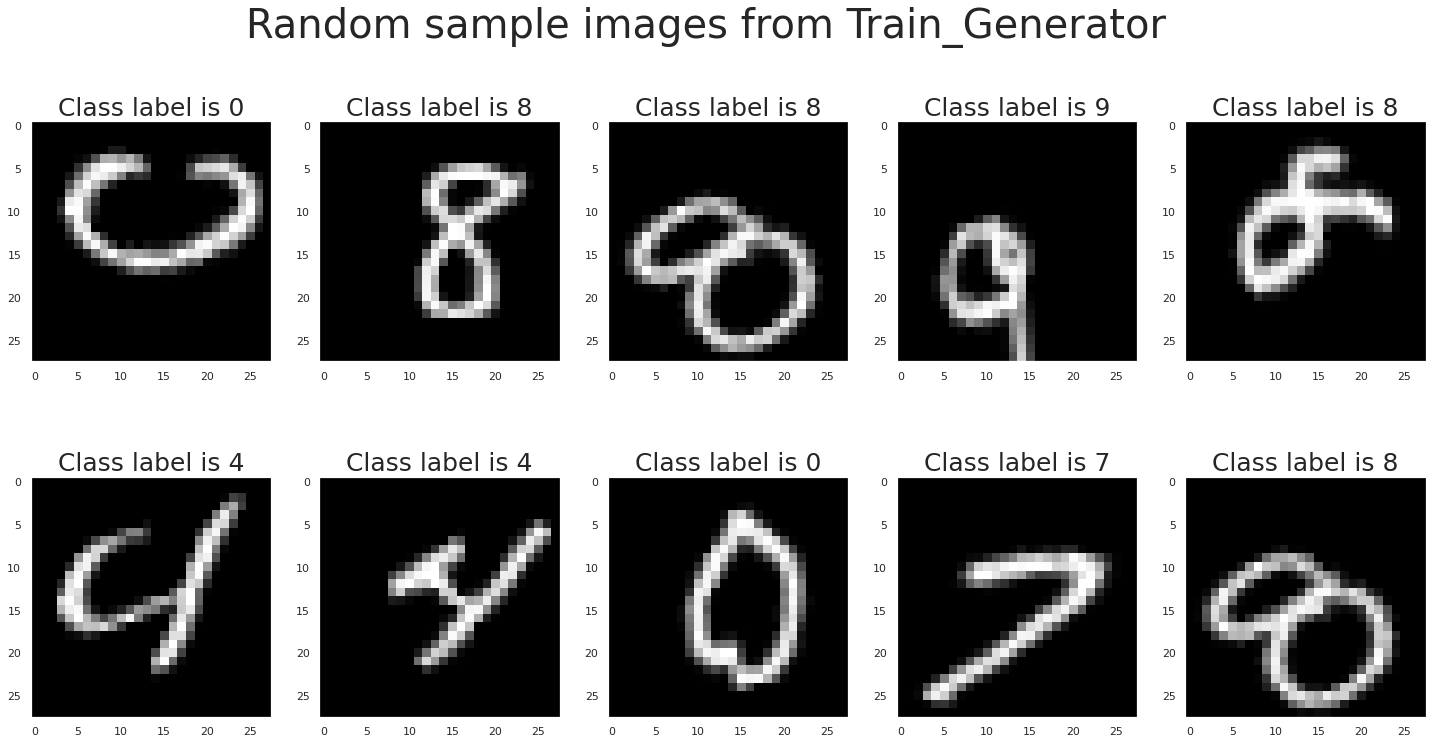

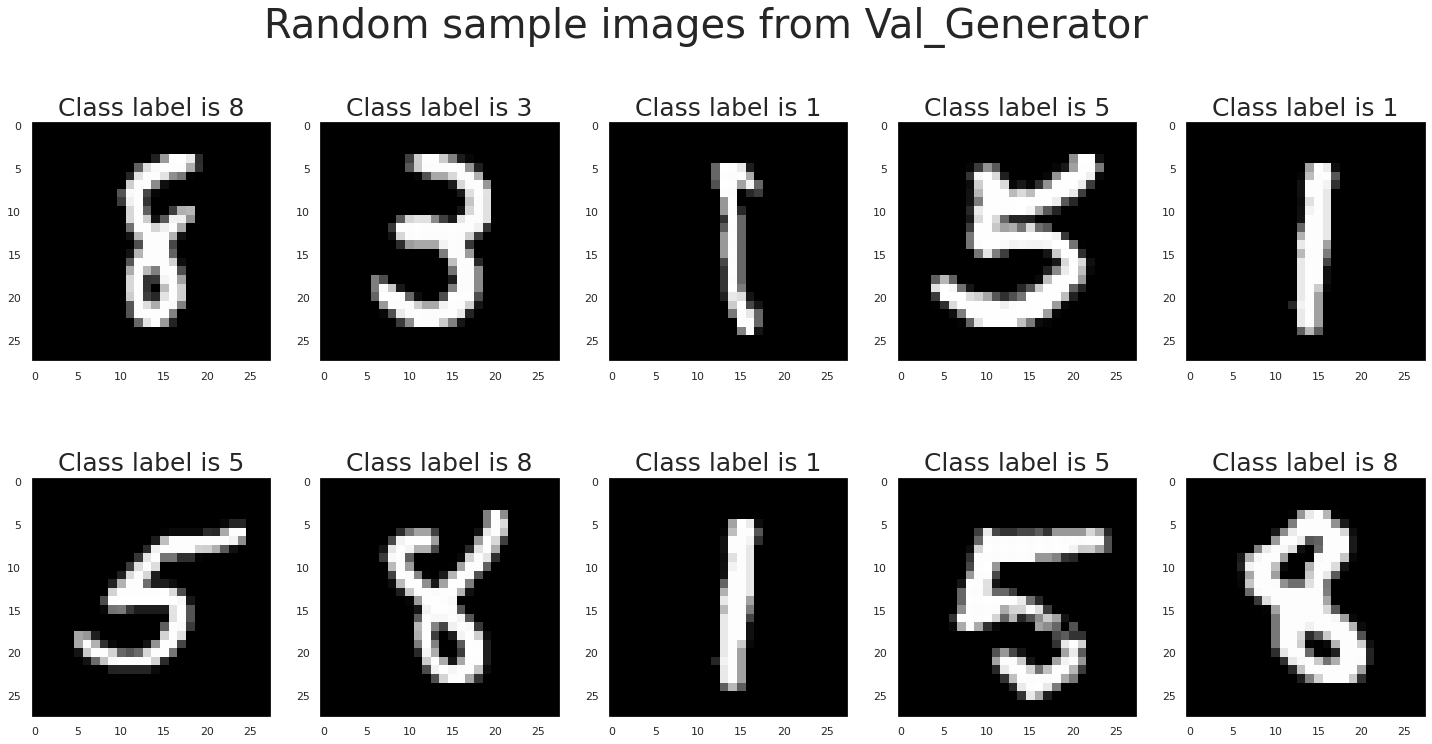

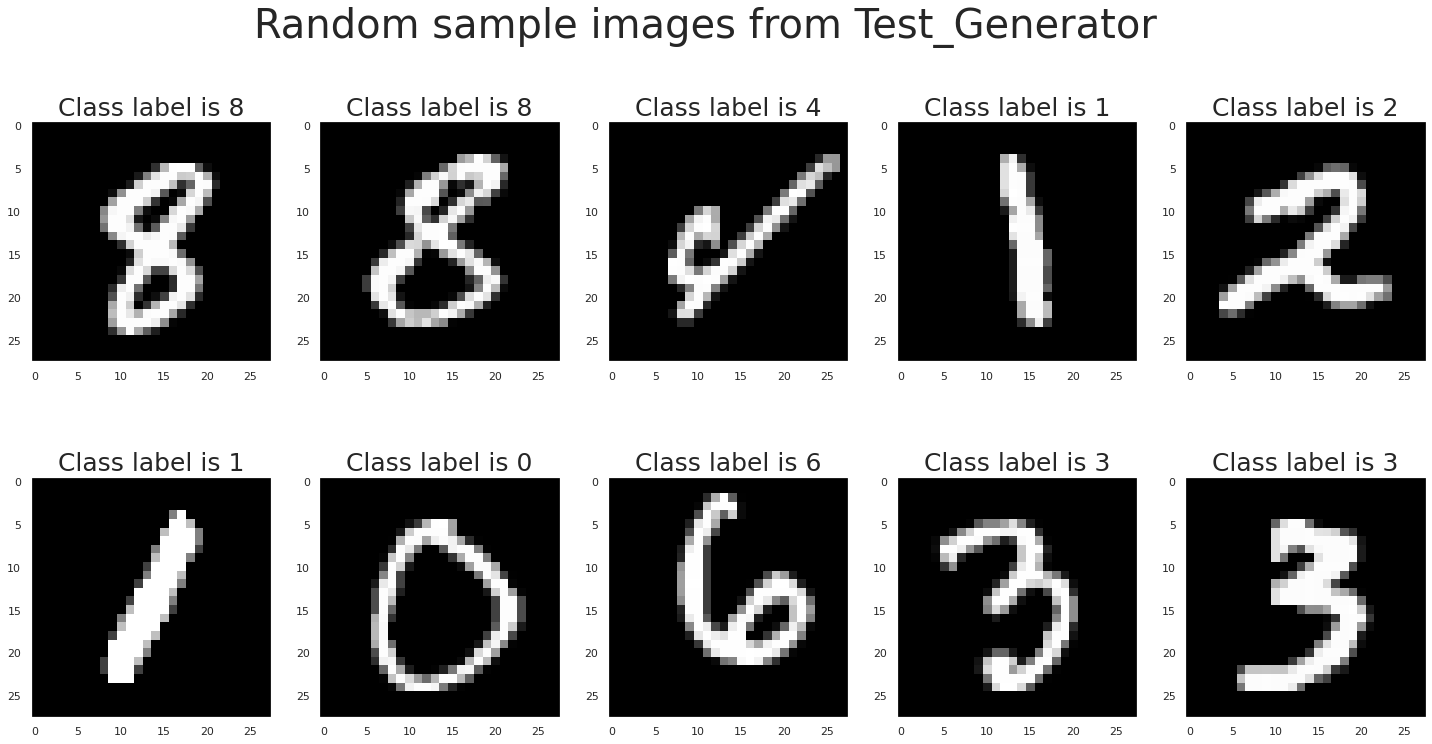

In [19]:
# Generate a batch of data from train_generator
X_batch, y_batch = next(train_generator)
y_batch = np.argmax(y_batch, axis = 1)
viz_data('Train_Generator', X_batch, y_batch, 'float', 'grayscale', num_images = 10, num_cols = 5,\
         col_size = 5, row_size = 6)
print("\n\n")
# Generate a batch of data from validation_generator
X_batch, y_batch = next(val_generator)
y_batch = np.argmax(y_batch, axis = 1)
viz_data('Val_Generator', X_batch, y_batch, 'float', 'grayscale', num_images = 10, num_cols = 5,\
         col_size = 5, row_size = 6)
print("\n\n")
# Generate a batch of data from test_generator
X_batch, y_batch = next(test_generator)
y_batch = np.argmax(y_batch, axis = 1)
viz_data('Test_Generator', X_batch, y_batch, 'float', 'grayscale', num_images = 10, num_cols = 5,\
         col_size = 5, row_size = 6)
print("\n\n")


# Models - Build, Train, Eval

## Functions

### Define Model Core

In [20]:
def model_core(model_dict):
    
    """
    Function to define the model core.
    
    Arguments:
      model_dict - Dictionary with list of keys / values needed to build the model

    Returns:
      model - Model with all layers instantiated
 
    """    
    # Retrieve model dict parameters
    model_arch = model_dict['model_arch'] # Model Architecture
    use_bnorm = model_dict['use_bnorm'] # Boolean, whether to use Batch Norm or not
    use_dropout = model_dict['use_dropout'] # Boolean, whether to use dropout or not
    dropout_rate = model_dict['dropout_rate'] # List containing dropout values for each layer

    ##### Start Model Architecture A
    if (model_arch == 'A'): 
      model = Sequential()

      # Stage-1: Conv2D -> BN -> ReLU -> Dropout -> Conv2D -> BN -> ReLU -> Dropout -> MaxPool2D
      model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1), name = 'C1'))
      if (use_bnorm): model.add(BatchNormalization(name = 'B1'))
      model.add(Activation('relu', name = 'A1'))
      if (use_dropout): model.add(Dropout(rate = dropout_rate[0], name = 'DR1'))    
      model.add(Conv2D(32, (3, 3), name = 'C2'))
      if (use_bnorm): model.add(BatchNormalization(name = 'B2'))
      model.add(Activation('relu', name = 'A2'))
      if (use_dropout): model.add(Dropout(rate = dropout_rate[1], name = 'DR2'))    
      model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'M1'))
      
      # Stage-2: Flatten -> Dense(128, ReLU) -> Dense(10, Softmax)
      model.add(Flatten(name = 'F1'))
      model.add(Dense(128, activation = 'relu', name = "D1"))
      model.add(Dense(10, activation = 'softmax', name = "OL"))
  
    ##### End Model Architecture A     
    
    return model

### Verify Model Core

In [21]:
# Verify model defined above
model_dict = {'model_arch': 'A',
              'use_bnorm': True,
              'use_dropout': True, 
              'dropout_rate': [0.0, 0.0]
              }
temp_model = model_core(model_dict)
temp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 26, 26, 32)        320       
_________________________________________________________________
B1 (BatchNormalization)      (None, 26, 26, 32)        128       
_________________________________________________________________
A1 (Activation)              (None, 26, 26, 32)        0         
_________________________________________________________________
DR1 (Dropout)                (None, 26, 26, 32)        0         
_________________________________________________________________
C2 (Conv2D)                  (None, 24, 24, 32)        9248      
_________________________________________________________________
B2 (BatchNormalization)      (None, 24, 24, 32)        128       
_________________________________________________________________
A2 (Activation)              (None, 24, 24, 32)        0

### Define Model_Compile

In [22]:
def model_compile(model, compile_dict):
    
    """
    Function to compile the model
    
    Arguments:
      model - Model instance that needs to be compiled
      compile_dict - Dictionary with list of keys / values needed to compile the model
 
    """    
    # Retrieve compile_dict parameters
    ilr = compile_dict['ilr'] # Initial learning rate to use for learning rate decay scheduler    
    dr = compile_dict['dr'] # Decay rate to use for learning rate decay scheduler    
    ds = compile_dict['ds'] # Decay step to use for learning rate decay scheduler
    redlr_plat = compile_dict['redlr_plat'] # Boolean: If True, implement reduce LR on plateau     

    lr_sch = InverseTimeDecay(ilr, ds, dr) # Inverse Time Decay LR scheduler
    # Define Optimizer
    if (redlr_plat):
      opt = optimizers.Adam(learning_rate = ilr) 
    else:
      opt = optimizers.Adam(learning_rate = lr_sch)
    loss = losses.CategoricalCrossentropy() # Define loss
    met = metrics.CategoricalAccuracy() # Define metric

    # Compile model
    model.compile(optimizer = opt, loss = loss, metrics = met)

### Define Model_Fit

In [23]:
def model_fit(model, train_dict):
    
    """
    Function to fit the model
    
    Arguments:
      model - Model instance that needs to be trained
      train_dict - Dictionary with list of keys / values needed to fit the model      

    Returns:
      model - Final trained model
      hist - Model training history
    """   

    # Retrieve path parameters
    tb_path = train_dict['tb_path'] # Path to store Tensorboard callback information
    mc_path = train_dict['mc_path'] # File name to use for storing model checkpoints
    
    # Retrieve callback parameters
    mcp_freq = train_dict['mcp_freq'] # Number of batches after which model will be checkpointed    
    early_stop = train_dict['early_stop'] # Boolean: If True, implement early stop
    redlr_plat = train_dict['redlr_plat'] # Boolean: If True, implement reduce LR on plateau  
    lrpl_fac = train_dict['lrpl_fac'] # Factor to use for Reduce LR on Plateau callback
    lrpl_pat = train_dict['lrpl_pat'] # Patience to use for Reduce LR on Plateau callback    

    # Retrieve training parameters
    train_gen = train_dict['train_gen'] # Train Generator to use while fitting
    val_data = train_dict['val_gen'] # Validation Generator to use while fitting
    epochs = train_dict['epochs'] # Number of epochs to train for
    initial_epoch = train_dict['initial_epoch'] # Initial epoch to re-start training from
    train_steps_per_epoch = train_dict['train_steps_per_epoch'] # Number of steps per training epoch
    val_steps = train_dict['val_steps'] # Number of steps before stopping validation
    val_freq = train_dict['val_freq'] # Number of epochs to run before performing a validation run
    verb = train_dict['verb'] # Controls verbosity level of model fit.

    #### Start -  Define callbacks
    # Define path for tensorboard logs
    logdir = os.path.join(tb_path,\
                          datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d%m_%H%M"))
    # Define Tensorboard callback
    tensorboard_callback = TensorBoard(logdir, histogram_freq = 0)
    # Define Model Checkpoint callback
    mcp_callback = ModelCheckpoint(filepath = mc_path, save_freq = mcp_freq, verbose = 0)
    # Define Early Stopping callback
    earlystopping_callback = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 10,\
                                           mode = "min", verbose = 1)
    # Define 'Reduce learning rate on plateau' callback
    redlr_plat_callback = ReduceLROnPlateau(monitor = "val_loss", factor = lrpl_fac, patience = lrpl_pat,\
                                            verbose = 1, mode = "min", min_delta = 0.0001)
    # Define list of all callbacks
    callback_list = []
    if (tb_path != None): callback_list.append(tensorboard_callback)
    if (mc_path != None): callback_list.append(mcp_callback)
    if (early_stop): callback_list.append(earlystopping_callback)    
    if (redlr_plat): callback_list.append(redlr_plat_callback)
    #### End -  Define callbacks 
    
    #### Start - Model Fit
    hist = model.fit(x = train_gen, validation_data = val_data, epochs = epochs,\
                     initial_epoch = initial_epoch, steps_per_epoch = train_steps_per_epoch,\
                     validation_steps = val_steps, validation_freq = val_freq,
                     callbacks = callback_list, verbose = verb)
    #### End - Model Fit   

    return model, hist

### Define Model_Train

In [24]:
def model_train(model_dict, compile_dict, train_dict, model = None):
  """
  Function to instantiate (or load) model, compile and fit model.
    
  Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
    compile_dict - Dictionary with list of keys / values needed to compile the model
    train_dict - Dictionary with list of keys / values needed to train the model
    model - Pre-trained model (Pass this as input only if fit_resume = True and load_model = False)
    
  Returns:
    model - Final trained model
    hist - Model training history
 
  """   
  # Retrieve train_dict parameters
  fit_resume = train_dict['fit_resume'] # Boolean: If True, resume fit from initial epoch
  load_model = train_dict['load_model'] # Boolean: If True, load model from 'fm_path' and resume fit  
  recompile = train_dict['recompile'] # Boolean: If True, recompile model before resuming fit  
  fm_path = train_dict['fm_path'] # File name to use for storing final trained model
  hi_path = train_dict['hi_path'] # File name to use for storing training history

  if (not(fit_resume)): # fit_resume = False => instantiating new model
    print("Instantiating new model...", end = ', ')
    model = model_core(model_dict) # Instantiate new model
    print("Compiling model...", end = ', ')
    model_compile(model, compile_dict) # Compile model
    print("Model Fit started....", end = ', ')    
    model, hist = model_fit(model, train_dict) # Fit model
  else: # fit_resume = True => Proceed with existing model in memory or load model from disk
    if (load_model): # load_model = True => Load model from disk
      print("Loading model from disk...", end = ', ')
      model = models.load_model(fm_path) # Reload model from disk
      if (recompile): # Re-compile model if "recompile" = True
        print("Re-Compiling model...", end = ', ')
        model_compile(model, compile_dict) 
      print("Resuming model fit....", end = ', ')
      model, hist = model_fit(model, train_dict) # Resume model fit
    else: # load_model = False => Proceed with existing model in memory
      if (recompile): # Re-compile model if "recompile" = True
        print("Re-compiling model...", end = ', ')
        model_compile(model, compile_dict)
      print("Resuming model fit....", end = ', ')
      model, hist = model_fit(model, train_dict) # Resume model fit

  # Save final trained model and history to file
  if (fm_path != None): model.save(fm_path, overwrite = True, save_format = 'h5') 
  if (hi_path != None): np.save(hi_path, hist.history)

  return model, hist

## Classes

### Define HyperModel Class (For Hyperparameter Tuning)

In [25]:
class MyHyperModel(HyperModel):

  def __init__(self, model_dict, compile_dict, hp_dict):
    self.model_dict_tune = model_dict.copy() # Dictionary of default model parameters
    self.compile_dict_tune = compile_dict.copy() # Dictionary of default compilation parameters
    self.hp_dict = hp_dict # Dictionary of hyperparameters to tune

  def build(self, hp):
    hp_list = [] # List placeholder to define all hyperparameters
    for ind in range(len(hp_dict)): # Update hp_list based on hp_dict
      if (hp_dict[ind][0] == 'choice'): hp_list.append(hp.Choice(name = hp_dict[ind][1],\
                                                                 values = hp_dict[ind][2],\
                                                                 ordered = hp_dict[ind][3]))    
    # Set hyperparameters in model_dict_tune
    self.model_dict_tune['dropout_rate'] = [hp_list[0], hp_list[1]]

    model = model_core(self.model_dict_tune) # Instantiate model
    model_compile(model, self.compile_dict_tune) # Compile model    
   
    return model

## Set model_core, model_compile, model_train parameters

In [26]:
### Define file paths
mod_file_pref = "MA" # Prefix to use for naming files and paths
tb_path = os.path.join(tb_logs_base_path, mod_file_pref) # Tensorboard base path
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") # Final trained model path
mc_path = os.path.join(out_base_path, mod_file_pref + "_EP{epoch:04d}.h5") # Model checkpoints path
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy") # Training history path

# Set model_dict values
model_dict = {'model_arch': 'A',
              'use_bnorm': True,
              'use_dropout': True, 
              'dropout_rate': [0.0, 0.0]
              }
# Set compile_dict values
compile_dict = {'ilr': 1e-3, # Initial learning rate to use for learning rate decay scheduler    
                'dr': 1, # Decay rate to use for learning rate decay scheduler
                'ds': (len(train_generator) * 10), # Decay rate to use for learning rate decay scheduler
                'redlr_plat': False, # Boolean: If True, implement reduce LR on plateau  
               }
# Set train_dict values               
train_dict = {'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'load_model': False, # Boolean: If True, load model from 'fm_path' and resume fit
              'recompile': False, # Boolean: If True, recompile model before resuming fit
              'train_gen': train_generator, # Train generator to use while fitting
              'val_gen': val_generator, # Validation generator to use while fitting
              'epochs': 10, # Number of epochs to train for              
              'initial_epoch': 0, # Initial epoch to start from              
              'train_steps_per_epoch': len(train_generator), # No. of steps per epoch
              'val_steps': len(val_generator), # No. of steps before stopping eval of val set
              'val_freq': 1, # Number of epochs to run before performing a validation run
              'verb': 1, # Controls verbosity level of model fit.
              'mcp_freq': (len(train_generator) * 500), # Checkpoint model after mcp_freq batches
              'early_stop': False, # Boolean: If True, implement early stop
              'redlr_plat': compile_dict['redlr_plat'], # Boolean: If True, implement reduce LR on plateau
              'lrpl_fac': 0.5, # Factor to use for Reduce LR on Plateau callback
              'lrpl_pat': 10, # Patience to use for Reduce LR on Plateau callback              
              'tb_path': tb_path, # Path to store Tensorboard callback information
              'mc_path': mc_path, # File name to use for storing model checkpoints
              'fm_path': fm_path, # File name to use for storing final trained model
              'hi_path': hi_path, # File name to use for storing training history
              }

print(tb_path)
print(mc_path)
print(fm_path)
print(hi_path)

/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/TB_Logs/MA
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/Training_Outputs/MA_EP{epoch:04d}.h5
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/Training_Outputs/MA_finalmodel.h5
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/Training_Outputs/MA_hist.npy


## Launch Tensorboard

In [ ]:
%tensorboard --logdir {tb_logs_base_path}

## Train Model

In [ ]:
# Get start time of run and display it
start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# Instantiate, compile and fit model
if (train_dict['fit_resume'] and not(train_dict['load_model'])):
  model, hist = model_train(model_dict, compile_dict, train_dict, model)
else:
  model, hist = model_train(model_dict, compile_dict, train_dict)

# Get end time of run and display elapsed time
end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
elap_time = ((end_time - start_time).total_seconds())/60
print("\nCompleted at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time))

## Hyperparameter Tuning

In [ ]:
project_name = "MA_DR_Tune" # Directory to store results of hyperparameter tuning

# Define hyperparameters in hp_dict
hp_dict = {0: ['choice', 'Dropout_0', [0.2, 0.3, 0.4, 0.5], True],
           1: ['choice', 'Dropout_1', [0.2, 0.3, 0.4, 0.5], True],
           }

# Instantiate hypermodel           
hypermodel = MyHyperModel(model_dict, compile_dict, hp_dict) 

# Instantiate Tuner
tuner = kt.RandomSearch(hypermodel, objective = 'val_categorical_accuracy', max_trials = 2,\
                        seed = 1234, directory = kt_logs_base_path, project_name = project_name)

# Display Hyperparameter Search Space
tuner.search_space_summary()

In [ ]:
# Run hyperparameter search
tuner.search(x = train_dict['train_gen'], validation_data = train_dict['val_gen'],\
             epochs = 2, steps_per_epoch = train_dict['train_steps_per_epoch'],\
             validation_steps = train_dict['val_steps'], verbose = 1)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0].get_config()['values']
print()
print("Best Hyperparameters:")
print("---------------------")
print(best_hps)

# best_hps_dict = tuner.get_best_hyperparameters(num_trials = 1)[0]
# best_model = tuner.hypermodel.build(best_hps_dict)
# best_model.summary()

# Results Summary

## Define Functions

### Function: get_model

In [27]:
def get_model(mod_file_prefix, print_summary = False):
  '''
  Function to return required paths, loaded model and print model summary

  Arguments:
    mod_file_prefix: # Prefix of model file name
    print_summary: Boolean. If True, print model summary
  '''
  fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") # Final model path
  hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy") # History file path
  
  # Load model with final trained weights
  model = models.load_model(fm_path) 
  
  # Print model summary
  if (print_summary):
    display(model.summary())

  return fm_path, hi_path, model

### Function: plot_lc

In [28]:
def plot_lc(mod_file_pref, hi_path, hist_plot_dict, num_cols, col_size, row_size):
  '''
  Function to plot learning curves 

  Arguments:
    hi_path: path of history file
    hist_plot_dict: Dictionary containing items to plot
    num_cols: Number of columns to use for plotting
    col_size: Column width to use while plotting
    row_size: Row width to use while plotting
  '''
  hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()
  
  num_plots = len(hist_plot_dict)
  num_rows = math.ceil(num_plots / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)

  for ind, value in enumerate(hist_plot_dict.items()):
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    for key in value[1][0].keys():
      ax.plot(hist_model[key], value[1][0][key][0], label = value[1][0][key][1])     
      ax.set_title(value[1][1], fontsize = 20)
      ax.set_ylabel(value[1][2], fontsize = 20)
      ax.set_xlabel(value[1][3], fontsize = 20)
      ax.grid(b = True)
      ax.legend(fontsize = 15)

### Function: plot_cm

In [124]:
def plot_cm(train_gen, val_gen, test_gen, y_train, y_val, y_test, row_size, col_size):

  '''
  Function to plot confusion matrices for train, val and test sets

  Arguments:
    train_gen: Train generator without augmentation and shuffling
    val_gen: Validation generator without augmentation and shuffling
    test_gen: Test generator without augmentation and shuffling
    y_train: Ground-truth training set labels
    y_val: Ground-truth validation set labels
    y_test: Ground-truth testing set labels
    row_size: Row size to use for plotting
    col_size: Column size to use for plotting
  '''

  # Obtain predicted labels for training, validation and testing sets
  y_train_pred = np.argmax(model.predict(x = train_gen, steps = len(train_gen), verbose = 0), axis = 1)
  y_val_pred = np.argmax(model.predict(x = val_gen, steps = len(val_gen), verbose = 0), axis = 1)
  y_test_pred = np.argmax(model.predict(x = test_gen, steps = len(test_gen), verbose = 0), axis = 1)    

  # Generate confusion matrices
  cm_train = tf.math.confusion_matrix(y_train, y_train_pred).numpy()
  cm_val = tf.math.confusion_matrix(y_val, y_val_pred).numpy()  
  cm_test = tf.math.confusion_matrix(y_test, y_test_pred).numpy()

  # Convert confusion matrices to pandas DF
  index = [('A' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
  columns = [('P' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
  cm_train_df = pd.DataFrame(cm_train, index = index, columns = columns)
  cm_val_df = pd.DataFrame(cm_val, index = index, columns = columns)  
  cm_test_df = pd.DataFrame(cm_test, index = index, columns = columns)

  # Plot confusion matrices
  fig = plt.figure(figsize = (col_size, (3 * row_size)))

  ax1 = plt.subplot(3, 1, 1)
  sns.heatmap(cm_train_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax1)
  ax1.set_title("Confusion Matrix for Training set", fontsize = 25)
  ax1.tick_params(labelsize = 20)

  ax2 = plt.subplot(3, 1, 2)
  sns.heatmap(cm_val_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax2)
  ax2.set_title("Confusion Matrix for Validation set", fontsize = 25)
  ax2.tick_params(labelsize = 20)

  ax3 = plt.subplot(3, 1, 3)
  sns.heatmap(cm_test_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax3)
  ax3.set_title("Confusion Matrix for Test set", fontsize = 25)
  ax3.tick_params(labelsize = 20)  

  plt.show() 

## Model_1: CNN_1

* Input shape = (28 x 28 x 1)
* Layers:

    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (26 x 26 x 32). 
    * Activation = 'ReLU'
    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (24 x 24 x 32)
    * Activation = 'ReLU'
    * Flatten: Output shape = (18432 x 1)
    * Dense: Output shape = (128 x 1)
    * Activation = 'ReLU'
    * Dense: Output shape = (10 x 1)
    * Activation = 'Softmax'


### Define file paths

In [29]:
mod_file_pref = "MA"
fm_path, hi_path, model = get_model("MA", False)

### Plot learning curves

In [ ]:
hist_plot_dict = {0: [{'loss': ['r-', 'Training_Set_Loss'],
                       'val_loss': ['b-', 'Validation_Set_Loss']},
                      'Loss vs. #Epoch', 'Loss', '# Epochs'],
                  1: [{'categorical_accuracy': ['r-', 'Training_Set_Accuracy'],
                      'val_categorical_accuracy': ['b-', 'Validation_Set_Accuracy']},
                      'Accuracy vs. #Epoch', 'Accuracy', '# Epochs']
                  }
plot_lc(mod_file_pref, hi_path, hist_plot_dict, 2, 7, 7)

### Evaluate model on training and test sets

In [38]:
# Evaluate model on training set
res = model.evaluate(x = train_generator, steps = len(train_generator), verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator, steps = len(val_generator), verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on test set
res = model.evaluate(x = test_generator, steps = len(test_generator), verbose = 0, return_dict = True)
print("Test set loss is %0.4f" % res['loss'])
print("Test set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.1253
Training set accuracy is 96.22 %

Validation set loss is 0.0736
Validation set accuracy is 98.00 %

Test set loss is 0.0855
Test set accuracy is 97.51 %


### Plot Confusion matrix

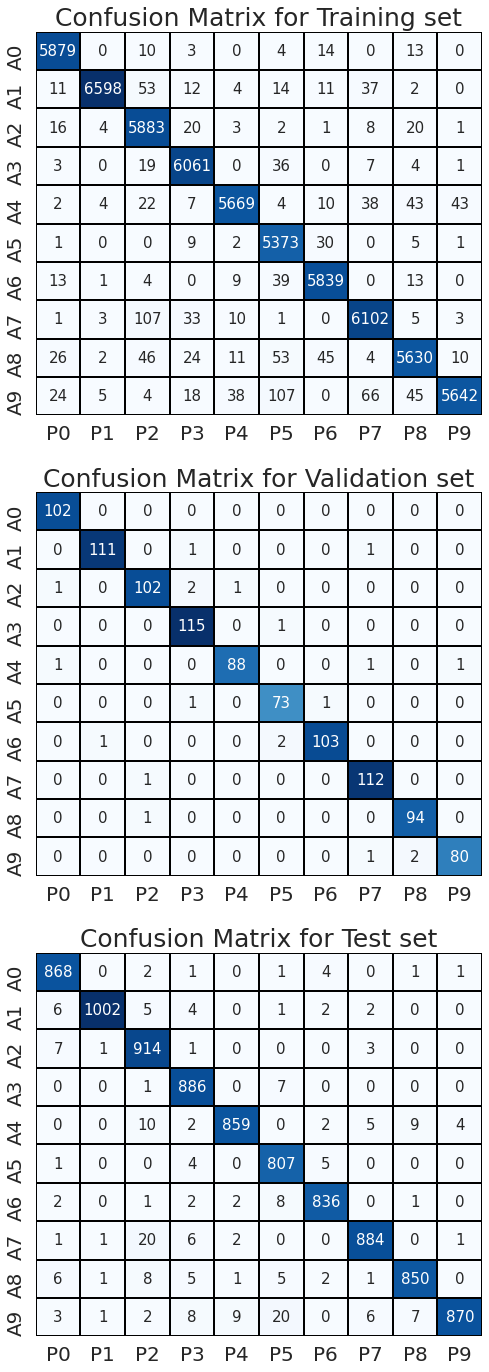

In [52]:
# Regenerate train, val and test generators without augmentation and shuffling
train_datagen_cm = ImageDataGenerator(rescale = 1./255)
val_datagen_cm = ImageDataGenerator(rescale = 1./255)
test_datagen_cm = ImageDataGenerator(rescale = 1./255)

train_gen_cm = train_datagen_cm.flow(X_train, y_train_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)
val_gen_cm = val_datagen_cm.flow(X_val, y_val_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)
test_gen_cm = test_datagen_cm.flow(X_test, y_test_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)

plot_cm(train_gen_cm, val_gen_cm, test_gen_cm, y_train, y_val, y_test, 8, 8)

# Backup

### Visualize intermediate outputs

In [ ]:
# Load M3A model
mod_file_pref = "M3B" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5")
model = models.load_model(fm_path) 

c1 = model.layers[0] # Extract first conv layer (without activation)
a1 = model.layers[1] # Extract first ReLU activation layer
c2 = model.layers[2] # Extract second conv layer (without activation)
a2 = model.layers[3] # Extract second ReLU activation layer

ind = 20 # Define sample index to evaluate
fil1 = 5 # Define filter of first conv layer to evaluate
fil2 = 7 # Define filter of second conv layer to evaluate

# Define input and outputs of first four layers of model
X = X_train[ind:(ind+1), :, :, :]
X1 = c1(X)
X2 = a1(X1)
X3 = c2(X2)
X4 = a2(X3)

fig = plt.figure(figsize = (12, 8))

ax1 = plt.subplot(2, 3, 1)
ax1.set_title("Input_Image", fontsize = 15)
ax1.imshow(X[0, :, :, 0], cmap = 'gray')

ax2 = plt.subplot(2, 3, 2)
ax2.set_title("First conv layer output", fontsize = 15)
ax2.imshow(X1[0, :, :, fil1], cmap = 'gray')

ax3 = plt.subplot(2, 3, 3)
ax3.set_title("First activation layer output", fontsize = 15)
ax3.imshow(X2[0, :, :, fil1], cmap = 'gray')

ax4 = plt.subplot(2, 3, 4)
ax4.set_title("Second conv layer output", fontsize = 15)
ax4.imshow(X3[0, :, :, fil2], cmap = 'gray')

ax5 = plt.subplot(2, 3, 5)
ax5.set_title("Second activation layer output", fontsize = 15)
ax5.imshow(X4[0, :, :, fil2], cmap = 'gray')

plt.show()

### Make Predictions

In [ ]:
# Make predictions on the test set for a given label
label = 5 # Actual label for which prediction will be done
act_ind = np.nonzero(y_test == label)[0] # Indices in test set corresponding to above label

# Obtain indices corresponding to correct and incorrect predictions for the given label
incorr_pred_ind = act_ind[np.nonzero(y_test_pred[act_ind] != label)[0]]
corr_pred_ind = np.setdiff1d(act_ind, incorr_pred_ind)

fig = plt.figure(figsize = (10, 5))

# Example of a correct prediction
ax1 = plt.subplot(1, 2, 1)
ind = np.random.choice(corr_pred_ind, 1) # Choose a random index from corr_pred_ind
X = X_test[ind[0], :, :, 0]
plt.imshow(X, cmap = 'gray');
temp = plt.text(4, -11, 'Correct Prediction', fontsize = 'xx-large')
temp = plt.text(2, -8, 'Sample index is %d' % ind[0], fontsize = 'xx-large')
temp = plt.text(5, -5, 'Actual label is %d' % y_test[ind[0]], fontsize = 'xx-large')
temp = plt.text(3, -2, 'Prediced label is %d' % y_test_pred[ind[0]], fontsize = 'xx-large')

# Example of an incorrect prediction
ax2 = plt.subplot(1, 2, 2)
ind = np.random.choice(incorr_pred_ind, 1) # Choose a random index from incorr_pred_ind
X = X_test[ind[0], :, :, 0]
plt.imshow(X, cmap = 'gray');
temp = plt.text(4, -11, 'Incorrect Prediction', fontsize = 'xx-large')
temp = plt.text(2, -8, 'Sample index is %d' % ind[0], fontsize = 'xx-large')
temp = plt.text(5, -5, 'Actual label is %d' % y_test[ind[0]], fontsize = 'xx-large')
temp = plt.text(4, -2, 'Prediced label is %d' % y_test_pred[ind[0]], fontsize = 'xx-large')